 #! sudo pip install time
 #! sudo pip install pyalsaaudio 
(перед этим On Debian or Ubuntu, install libasound2-dev.
 On Arch, install alsa-lib. а если будут еще проблемы, то https://github.com/larsimmisch/pyalsaaudio)
 #! sudo pip install aubio

#! А если еще что-то не понятно, то есть набор примеров, нормальной документации у них нет

 https://github.com/aubio/aubio/blob/master/python/demos/demo_alsa.py
 #! Как работает запись: пишется все риалтайме, так чтобы получить порцию данных запустите первый блок, спойте/поставьте музыку, нажмите на стоп

In [139]:
import alsaaudio
import numpy as np
import aubio
import time

# constants
samplerate = 44100
win_s = 2048
hop_s = win_s // 2
framesize = hop_s

#установка микрофона
recorder = alsaaudio.PCM(type=alsaaudio.PCM_CAPTURE)
recorder.setperiodsize(framesize)
recorder.setrate(samplerate)
recorder.setformat(alsaaudio.PCM_FORMAT_FLOAT_LE)
recorder.setchannels(1)

# create aubio pitch detection (first argument is method, "default" is
# "yinfft", can also be "yin", "mcomb", fcomb", "schmitt").
pitcher = aubio.pitch("default", win_s, hop_s, samplerate)
# set output unit (can be 'midi', 'cent', 'Hz', ...)
pitcher.set_unit("Hz")
# ignore frames under this level (dB)
pitcher.set_silence(-20)

print("Starting to listen, press Ctrl+C to stop")

f = np.array([])
en = np.array([])
now = time.time() 
times = np.array([])
# поток считывается пока вы не нажмете на стоп
while True:
    try:
        # read data from audio input
        _, data = recorder.read()
        # конвертим data в aubio float samples
        samples = np.fromstring(data, dtype=aubio.float_type)
        # высота нынешнего frame
        freq = pitcher(samples)[0]
        # они считают магически энергию, по тому что я пробовал, это похоже на громкость
        energy = np.sum(samples**2)/len(samples)
        #кидаем в массив частот энергии и времени
        f = np.append(f, freq)
        en = np.append(en, energy)
        times =np.append(times, time.time() - now)
        now = time.time()
    except KeyboardInterrupt:
        freq = f
        energy = en
        break

Starting to listen, press Ctrl+C to stop


In [170]:
silent_midi = -1 # если не слышно или просто ничего не звучит, то выдавать это midi

In [220]:
def frequnecy_to_midi(frequency):
    return np.int_(np.round(12 * np.log2(frequency / 440) + 69))

In [233]:
def to_midi(f):
    Midi = frequnecy_to_midi(f)
    Midi[Midi < 2] = silent_midi
    return Midi
midi = to_midi(freq)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app


In [234]:
import matplotlib.pyplot as plt

In [235]:
x = np.arange(len(freq))


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app


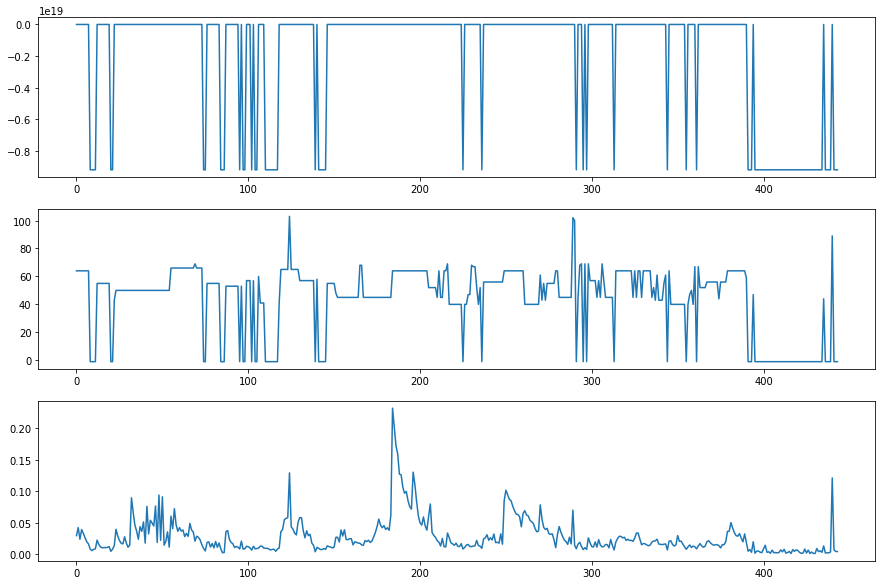

In [236]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
plt.plot(x, frequnecy_to_midi(freq)) #  если частоста 0, то midi  минус бесконечность и не отображается на графике
plt.subplot(312)
plt.plot(x, midi) # для частоты 0 midi -1 
plt.subplot(313)
plt.plot(x, energy)
plt.show()
#ошибка в конце из-за того что логарифм 0 минус бесконечность

Исследование сколько длиться один такт

 #### 50 sek - 2090 frames 41fps 
 ####  30 sek - 1285 frames 42.8fps
 #### 20 sek - 920 frames 46 fps

 #### time = N*hop_s / samplerate; N количество тактов, размер массива freq 
 #### time / N = hop_s / samperate  время которое длится один такт

In [238]:
n = len(freq)
energy_const = 0.0
time = hop_s / samplerate 

In [239]:
for i in range(n):
    if (energy[i] < energy_const):
          midi[i] = silent_midi

chords = [[-1, 0]]

cnt = times[0]
for i in range(1, n):
    if (abs(midi[i] - midi[i - 1]) < 0.01):
        cnt += times[i]
    else:
        chords.append([midi[i - 1], cnt])
        cnt = times[i]
    

In [240]:
print(chords)

[[-1, 0], [64, 0.1922760009765625], [-1, 0.080479860305786133], [55, 0.20118618011474609], [-1, 0.040285825729370117], [43, 0.040070056915283203], [50, 0.72002863883972168], [66, 0.32026553153991699], [69, 0.040463685989379883], [66, 0.080118417739868164], [-1, 0.040252923965454102], [55, 0.20198965072631836], [-1, 0.080066919326782227], [53, 0.16113042831420898], [-1, 0.040116310119628906], [53, 0.040197610855102539], [-1, 0.040151119232177734], [57, 0.040179967880249023], [-1, 0.040067911148071289], [57, 0.040195226669311523], [-1, 0.040252923965454102], [60, 0.00012278556823730469], [41, 0.074743986129760742], [-1, 0.20107173919677734], [41, 0.00014257431030273438], [65, 0.1206810474395752], [103, 0.040095806121826172], [65, 0.12065863609313965], [57, 0.20094013214111328], [-1, 0.040509462356567383], [58, 0.00026726722717285156], [-1, 0.12062716484069824], [55, 0.12054586410522461], [48, 0.00014138221740722656], [45, 0.32214236259460449], [68, 0.040399789810180664], [45, 0.393815755